# Imports
---


In [ ]:
%pip install pykan


In [ ]:
import os
import numpy as np
from numpy.random import normal
from numpy.linalg import inv
from scipy.signal import cont2discrete
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from numpy import random
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
from kan import KAN
from kan.utils import create_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.metrics import accuracy_score
import sympy

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


# Loading Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

base_path = '/content/drive/My Drive/Work/01- Private/KAUST/KAUST Intership/Project/AGC Papers/KAN'



path_to_normal = os.path.join(base_path,"solution_no_attack.npy")
path_to_attacked = os.path.join(base_path,"solution_attacked.npy")

data_solution_no_attack = np.load(path_to_normal)
data_solution_attacked = np.load(path_to_attacked)
print("No Attack shape : " , data_solution_no_attack.shape)
print("Attack shape : " ,  data_solution_attacked.shape)


# Extract time points from the first solution's first row
time_points = data_solution_no_attack[0, 0, 2:]

# Exclude the time points row from the first solution
solution_no_attack = data_solution_no_attack[1:]
solution_attacked = data_solution_attacked[1:]

# Exclude the columns corresponding to u_1 and u_2
solution_no_attack = solution_no_attack[:, :, 2:]
solution_attacked = solution_attacked[:, :, 2:]


Nsol = solution_no_attack.shape[0]
dpoints = solution_no_attack.shape[2]
ndim = solution_no_attack.shape[1]
display(f"Number of solutions: {Nsol}",f"Number of datapoints per solution: {dpoints}", f"Number of measurments: {ndim}")



def set_random_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    np.random.seed(random_seed)
    random.seed(random_seed)

random_seed = 1234
set_random_seed(random_seed)


train_on_normal_only = False
percentage = 0.2            # Percentage of attacked solutions to be added to the training dataset

set_random_seed(random_seed)
# Splitting the data
from sklearn.model_selection import train_test_split
if train_on_normal_only:
    data_combined = np.concatenate((solution_no_attack, solution_attacked[0:int(percentage*Nsol)]))
    labels_combined = np.concatenate((np.zeros(solution_no_attack.shape[0]), np.ones(solution_attacked[0:int(percentage*Nsol)].shape[0])))

    train_features, test_features, train_labels, test_labels = train_test_split(data_combined, labels_combined, test_size=0.2, random_state=42)
    train_features_attacked, test_features_attacked, train_labels_attacked, test_labels_attacked = train_test_split(solution_attacked, np.ones(solution_attacked.shape[0]), test_size=0.2, random_state=42)

    # train_features[0:int(0.1*train_features.shape[0])] = train_features_attacked[0:int(0.1*train_features.shape[0])] # add 1% attacks for the model to accept label 1
    test_features = np.concatenate((test_features, test_features_attacked))
    test_labels  = np.concatenate((test_labels, test_labels_attacked))
else:
    # Combining the two datasets and creating labels (0 for no_attack, 1 for attacked)
    data_combined = np.concatenate((solution_no_attack, solution_attacked))
    labels_combined = np.concatenate((np.zeros(solution_no_attack.shape[0]), np.ones(solution_attacked.shape[0])))
    train_features, test_features, train_labels, test_labels = train_test_split(data_combined, labels_combined, test_size=0.2, random_state=2024)



No Attack shape :  (10001, 3, 302)
Attack shape :  (10001, 3, 302)


'Number of solutions: 10000'

'Number of datapoints per solution: 300'

'Number of measurments: 3'

In [ ]:
sample0 = data_solution_no_attack[0]
df = pd.DataFrame(sample0)
print(df)

   0    1    2    3    4    5    6    7    8    9    ...   292   293   294  \
0  0.2  0.0  0.0  0.2  0.4  0.6  0.8  1.0  1.2  1.4  ...  58.0  58.2  58.4   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

    295   296   297   298   299   300   301  
0  58.6  58.8  59.0  59.2  59.4  59.6  59.8  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[3 rows x 302 columns]


In [ ]:
def extract_features(X):  # X: shape (N, T, C)
    X = X.numpy() if isinstance(X, torch.Tensor) else X
    N, T, C = X.shape
    features = []

    for c in range(C):
        x_c = X[:, :, c]  # shape: (N, T)
        feats = np.stack([
            np.mean(x_c, axis=1),
            np.std(x_c, axis=1),
            np.min(x_c, axis=1),
            np.max(x_c, axis=1),
            skew(x_c, axis=1),
            kurtosis(x_c, axis=1),
        ], axis=1)  # shape: (N, num_features)
        features.append(feats)

    return np.concatenate(features, axis=1)

In [ ]:
# Converting the data to PyTorch tensors

train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
train_features_tensor = train_features_tensor.permute(0, 2, 1)
test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
test_features_tensor = test_features_tensor.permute(0, 2, 1)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)


X_train_feats = extract_features(train_features_tensor)  # shape: (16000, 3 × 6 = 18)
X_test_feats = extract_features(test_features_tensor)    # shape: (4000, 18)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feats)
X_test_scaled = scaler.transform(X_test_feats)

dataset = {}
dataset['train_input'] = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
dataset['test_input'] = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
dataset['train_label'] = torch.tensor(train_labels_tensor.reshape(-1, 1), dtype=torch.float32).to(device)
dataset['test_label'] = torch.tensor(test_labels_tensor.reshape(-1, 1), dtype=torch.float32).to(device)



print("Train data shape: {}".format(dataset['train_input'].shape))
print("Train target shape: {}".format(dataset['train_label'].shape))
print("Test data shape: {}".format(dataset['test_input'].shape))
print("Test target shape: {}".format(dataset['test_label'].shape))
print("====================================")

Train data shape: torch.Size([16000, 18])
Train target shape: torch.Size([16000, 1])
Test data shape: torch.Size([4000, 18])
Test target shape: torch.Size([4000, 1])


/tmp/ipython-input-35-2447838676.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset['train_label'] = torch.tensor(train_labels_tensor.reshape(-1, 1), dtype=torch.float32).to(device)
/tmp/ipython-input-35-2447838676.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset['test_label'] = torch.tensor(test_labels_tensor.reshape(-1, 1), dtype=torch.float32).to(device)


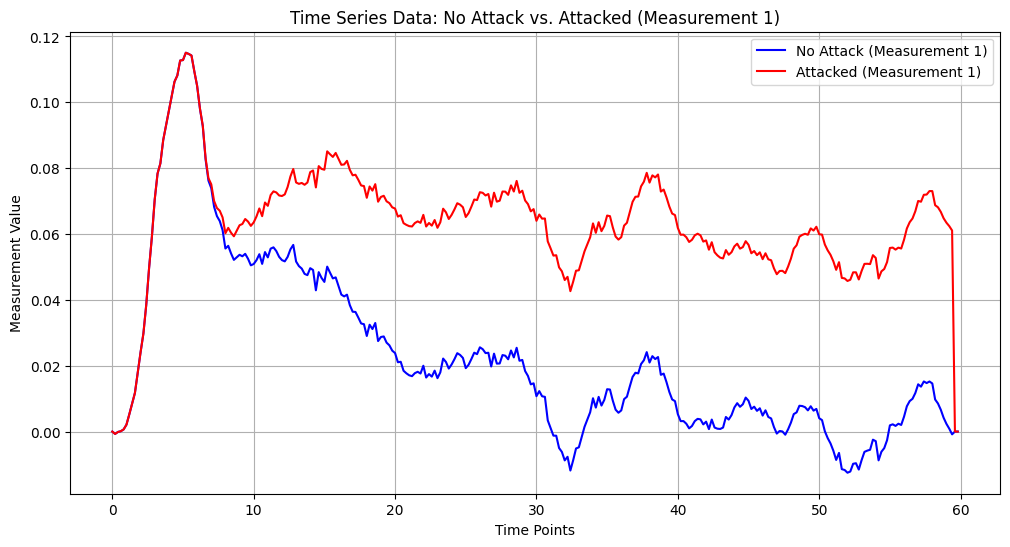

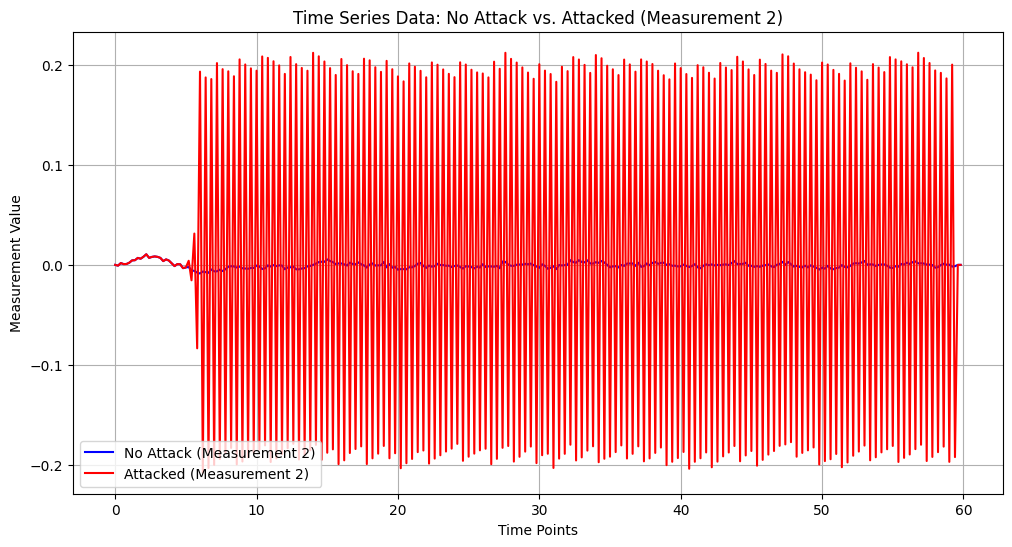

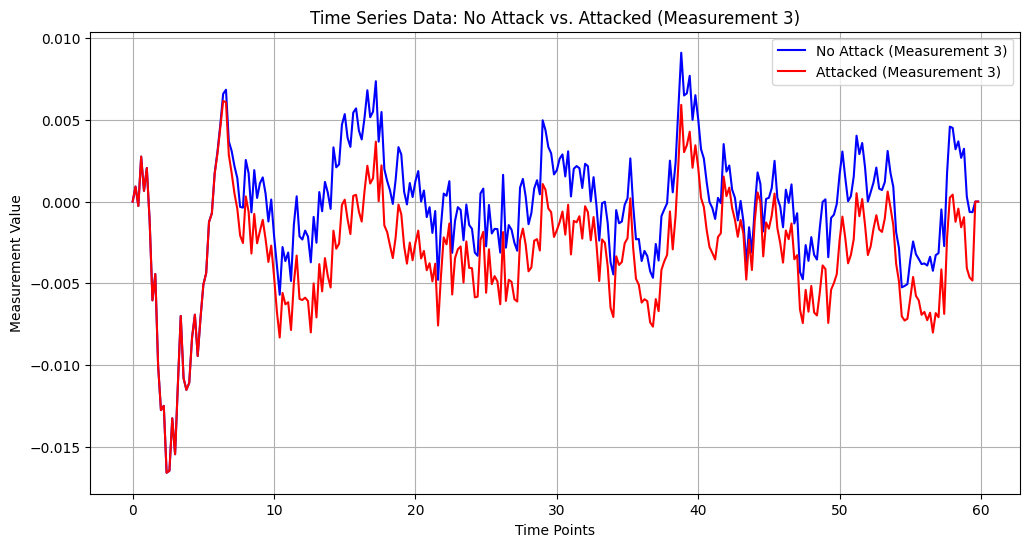

In [ ]:
# Plotting each measurement separately for no attack vs. attacked

# Plot for Measurement 1
plt.figure(figsize=(12, 6))
plt.plot(time_points, solution_no_attack[0, 0, :], label='No Attack (Measurement 1)', color='blue')
plt.plot(time_points, solution_attacked[0, 0, :], label='Attacked (Measurement 1)', color='red')
plt.xlabel('Time Points')
plt.ylabel('Measurement Value')
plt.title('Time Series Data: No Attack vs. Attacked (Measurement 1)')
plt.legend()
plt.grid(True)
plt.show()

# Plot for Measurement 2
plt.figure(figsize=(12, 6))
plt.plot(time_points, solution_no_attack[0, 1, :], label='No Attack (Measurement 2)', color='blue')
plt.plot(time_points, solution_attacked[0, 1, :], label='Attacked (Measurement 2)', color='red')
plt.xlabel('Time Points')
plt.ylabel('Measurement Value')
plt.title('Time Series Data: No Attack vs. Attacked (Measurement 2)')
plt.legend()
plt.grid(True)
plt.show()

# Plot for Measurement 3
plt.figure(figsize=(12, 6))
plt.plot(time_points, solution_no_attack[0, 2, :], label='No Attack (Measurement 3)', color='blue')
plt.plot(time_points, solution_attacked[0, 2, :], label='Attacked (Measurement 3)', color='red')
plt.xlabel('Time Points')
plt.ylabel('Measurement Value')
plt.title('Time Series Data: No Attack vs. Attacked (Measurement 3)')
plt.legend()
plt.grid(True)
plt.show()

#What are these mwasurments ??

In [ ]:
## Input features
dataset['train_input'].shape[1]

18

 ---
 # Model Training
 ---


## The model

In [ ]:
image_folder = 'video_img'
model = KAN(width=[dataset['train_input'].shape[1], 32, 1], grid=3, k=3, seed=2025, device=device)

model(dataset['train_input'])

checkpoint directory created: ./model
saving model version 0.0


tensor([[-3.7909e-02],
        [ 1.0720e-01],
        [-4.2976e-02],
        ...,
        [ 1.7999e-01],
        [ 3.4074e-03],
        [ 5.9647e-05]], device='cuda:0', grad_fn=<AddBackward0>)

## Print the model graph

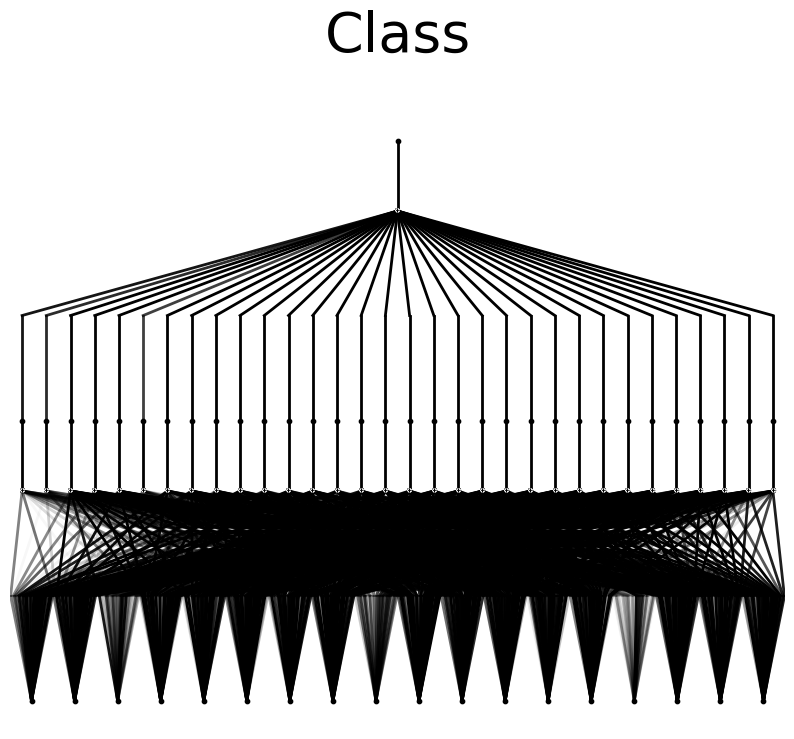

In [ ]:

model.plot(beta=100, scale=1 , out_vars=['Class'])

## Train the model

In [ ]:
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

Optimizer = "LBFGS"
Criterion = torch.nn.BCEWithLogitsLoss()

results = model.fit(dataset, opt=Optimizer , metrics=(train_acc, test_acc),
                      loss_fn=Criterion, steps=50, lamb=0.001,batch=128 , save_fig=False)

## To create Video
# results = model.fit(dataset, opt=Optimizer , metrics=(train_acc, test_acc),
#                       loss_fn=Criterion, steps=50, lamb=0.001, save_fig=True, img_folder=image_folder , batch=128, save_fig_freq=10)

| train_loss: 2.94e-02 | test_loss: 2.69e-01 | reg: 1.90e+01 | : 100%|█| 50/50 [00:19<00:00,  2.59it

saving model version 0.1


In [ ]:
print(model)

### The Model Metrics

Test Accuracy: 0.9718
Confusion Matrix:
[[2004    0]
 [ 113 1883]]


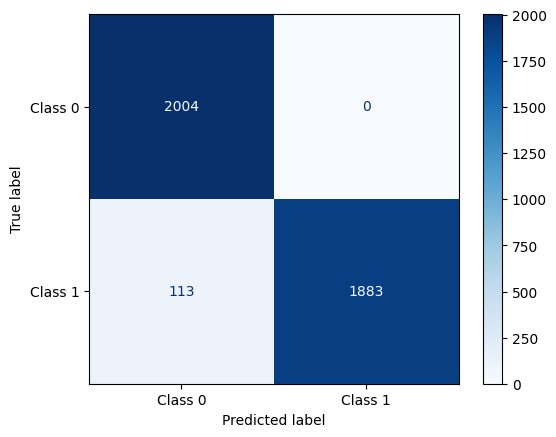

In [ ]:
from sklearn.metrics import accuracy_score

# Predict
y_test = dataset["test_label"].cpu().numpy().flatten()
y_pred_prob = model(dataset["test_input"]).detach().cpu().numpy().flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the matrix
print("Confusion Matrix:")
print(cm)

# Optionally, visualize it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap="Blues")

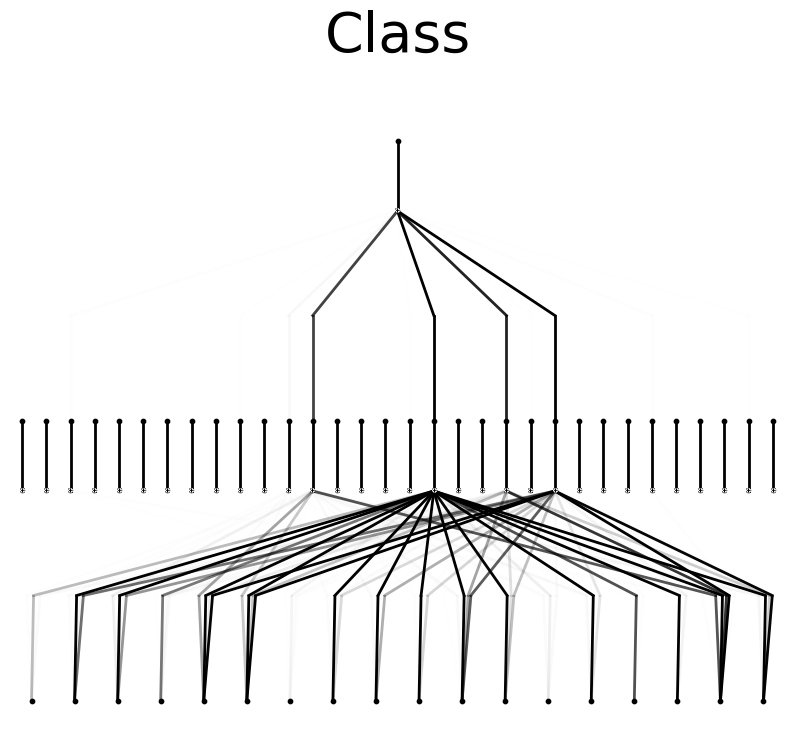

In [ ]:
model.plot(beta=100, scale=1 , out_vars=['Class'])

#### To show the Video of the model

In [ ]:
# import numpy as np # Import numpy here
# import moviepy.video.io.ImageSequenceClip # Import moviepy

# video_name='video'
# fps=10

# fps = fps
# files = os.listdir(image_folder)
# train_index = []
# for file in files:
#     if file[0].isdigit() and file.endswith('.jpg'):
#         train_index.append(int(file[:-4]))

# train_index = np.sort(train_index)

# image_files = [image_folder+'/'+str(train_index[index])+'.jpg' for index in train_index]

# clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
# clip.write_videofile(video_name+'.mp4')

### Find the symbolic equation using the Auto option / before Prune

In [ ]:

lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']


model.auto_symbolic(lib=lib)
formula1 = model.symbolic_formula()[0]
print(formula1)



fixing (0,0,0) with x, r2=0.003973616287112236, c=1
fixing (0,0,1) with x, r2=0.11109473556280136, c=1
fixing (0,0,2) with x, r2=0.2237793356180191, c=1
fixing (0,0,3) with x, r2=0.02085576392710209, c=1
fixing (0,0,4) with x, r2=0.03495090454816818, c=1
fixing (0,0,5) with x, r2=0.002122546313330531, c=1
fixing (0,0,6) with x, r2=0.00011196083505637944, c=1
fixing (0,0,7) with x, r2=0.0005014154594391584, c=1
fixing (0,0,8) with x, r2=0.0036682174541056156, c=1
fixing (0,0,9) with x, r2=0.09628120064735413, c=1
fixing (0,0,10) with x, r2=0.0002829676668625325, c=1
fixing (0,0,11) with x, r2=0.037750255316495895, c=1
fixing (0,0,12) with x, r2=0.0019357996061444283, c=1
fixing (0,0,13) with x, r2=0.005898184608668089, c=1
fixing (0,0,14) with x, r2=0.013498561456799507, c=1
fixing (0,0,15) with x, r2=0.023019813001155853, c=1
fixing (0,0,16) with x, r2=0.1126520112156868, c=1
fixing (0,0,17) with x, r2=0.34160059690475464, c=1
fixing (0,0,18) with x, r2=0.0096062570810318, c=1
fixing (

#### The formula

In [ ]:
# from sympy import *

# # Access the expression within the list before simplifying
# simplify(formula1[0])

KeyboardInterrupt: 

In [ ]:

print("Variables in symbolic formula 1:")
if isinstance(formula1[0], sympy.Expr):
    print([str(symbol) for symbol in formula1[0].free_symbols])
else:
    print("symbolic formula 1 is not a SymPy expression.")


feature_names = []
measurements = ["Measurement 1", "Measurement 2", "Measurement 3"]
metrics = ["mean", "std", "min", "max", "skew", "kurtosis"]

for i in range(3): # For each measurement (channel)
    for metric in metrics:
        feature_names.append(f"{metric}_{measurements[i]}")

# The symbolic variables x_0 to x_17 correspond to these feature_names in order.
# E.g., x_0 is mean_Measurement 1, x_1 is std_Measurement 1, ..., x_17 is kurtosis_Measurement 3.

print("\nAll possible input features (corresponding to x_0 to x_17):")
for i, name in enumerate(feature_names):
    print(f"x_{i}: {name}")

# Find missing variables in formula1[0] from the input features
present_variables_in_formula = set()
if isinstance(formula1[0], sympy.Expr):
    present_variables_in_formula = {str(symbol) for symbol in formula1[0].free_symbols}

all_input_variable_names = {f'x_{i}' for i in range(len(feature_names))}

missing_variables = all_input_variable_names - present_variables_in_formula

print("\nMissing variables in symbolic formula 1 from the input features:")
if missing_variables:
    missing_list = sorted(list(missing_variables), key=lambda x: int(x.split('_')[1]))
    for var in missing_list:
        index = int(var.split('_')[1])
        print(f"{var} ({feature_names[index]})")
else:
    print("No missing variables. The symbolic formula 1 uses all input features.")


Variables in symbolic formula 1:
['x_11', 'x_7', 'x_5', 'x_1', 'x_13', 'x_16', 'x_10', 'x_2', 'x_9', 'x_12', 'x_4', 'x_3', 'x_14', 'x_6', 'x_17', 'x_15', 'x_18', 'x_8']

All possible input features (corresponding to x_0 to x_17):
x_0: mean_Measurement 1
x_1: std_Measurement 1
x_2: min_Measurement 1
x_3: max_Measurement 1
x_4: skew_Measurement 1
x_5: kurtosis_Measurement 1
x_6: mean_Measurement 2
x_7: std_Measurement 2
x_8: min_Measurement 2
x_9: max_Measurement 2
x_10: skew_Measurement 2
x_11: kurtosis_Measurement 2
x_12: mean_Measurement 3
x_13: std_Measurement 3
x_14: min_Measurement 3
x_15: max_Measurement 3
x_16: skew_Measurement 3
x_17: kurtosis_Measurement 3

Missing variables in symbolic formula 1 from the input features:
x_0 (mean_Measurement 1)


#### The metrics of the Symbolic formula

Evaluating symbolic formula on test set: 100%|██████████| 4000/4000 [41:50<00:00,  1.59it/s]


Accuracy of the Symbolic Formula on the test set: 0.8850
Confusion Matrix for Symbolic Formula:
[[2003    1]
 [ 459 1537]]


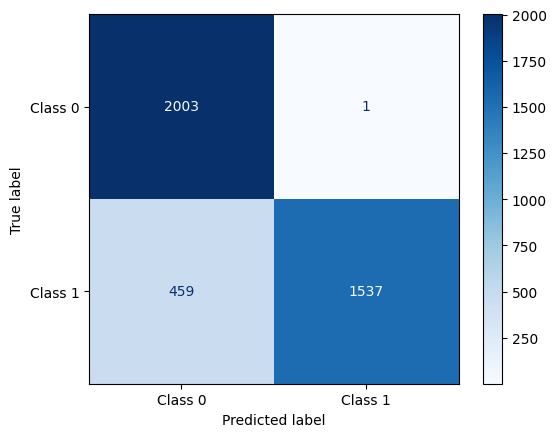

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm
import sympy

# Re-evaluating the symbolic formula on the test set
def kan_symbolic_formula_prediction_test(formula, X):
    batch = X.shape[0]
    predictions = []

    for i in tqdm(range(batch), desc="Evaluating symbolic formula on test set"):
        # Start with the base formula expression
        expression = formula


        substitutions = {sympy.Symbol(f'x_{j+1}'): X[i, j] for j in range(X.shape[1])}

        # Perform the substitution
        evaluated_expression = expression.subs(substitutions)

        # Evaluate the substituted expression numerically
        predicted = float(evaluated_expression.evalf())

        predictions.append(predicted)

    return predictions


preds_from_kan_formula_test1 = kan_symbolic_formula_prediction_test(formula1[0], dataset['test_input'].cpu().numpy())

# Convert the list of test predictions to a numpy array
preds_test_np1 = np.array(preds_from_kan_formula_test1)

# Convert raw predictions (logits) to predicted classes (0 or 1)
# Use the same threshold as the KAN model ( > 0 for BCEWithLogitsLoss)
predicted_classes_formula_test1 = (preds_test_np1 > 0).astype(float)

# Get the true test labels
true_labels_test1 = dataset['test_label'].cpu().numpy().flatten()

# Calculate accuracy on the test set
accuracy_formula_test1 = accuracy_score(true_labels_test1, predicted_classes_formula_test1)

print()

print(f"Accuracy of the Symbolic Formula on the test set: {accuracy_formula_test1:.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix for the symbolic formula predictions
cm_formula2 = confusion_matrix(true_labels_test1, predicted_classes_formula_test1)

# Print the matrix
print("Confusion Matrix for Symbolic Formula:")
print(cm_formula2)

# Optionally, visualize it
disp_formula = ConfusionMatrixDisplay(confusion_matrix=cm_formula2, display_labels=["Class 0", "Class 1"])
disp_formula.plot(cmap="Blues")

## Prune and fine tuning

saving model version 0.3


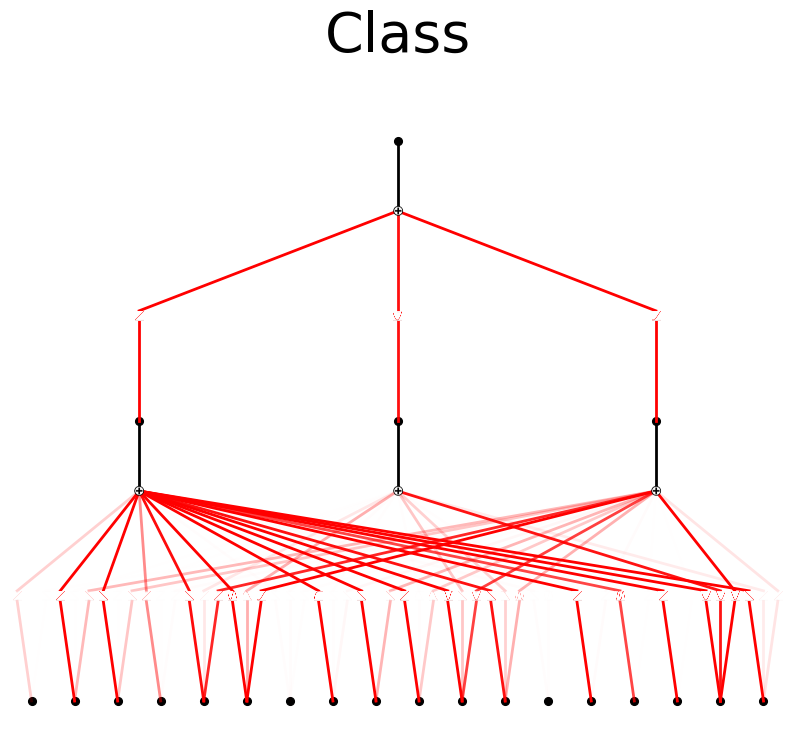

In [ ]:
model10 = model.prune()
model10(dataset['train_input'])
model10.plot(beta=100, scale=1 , out_vars=['Class'])

In [ ]:
# fine tune
Optimizer = "Adam" # Change optimizer to Adam
results_1 = model10.fit(dataset, opt=Optimizer, metrics=(train_acc, test_acc),
                      loss_fn=Criterion, steps=50, lamb=0.0001, batch=128 , lr=0.001) # Added lr for Adam

| train_loss: 1.07e+00 | test_loss: 1.63e+00 | reg: 0.00e+00 | : 100%|█| 50/50 [00:22<00:00,  2.26it

saving model version 0.6


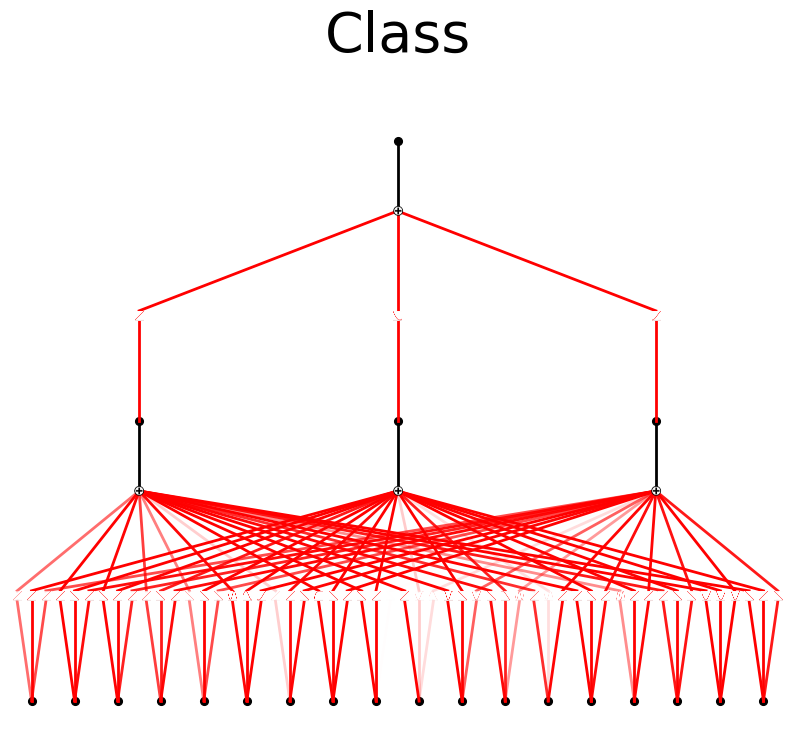

In [ ]:
model10(dataset['train_input'])
model10.plot(beta=100, scale=1 , out_vars=['Class'])

### The metrics of the fine tuned model

Test Accuracy: 0.9705
Confusion Matrix:
[[1995    9]
 [ 109 1887]]


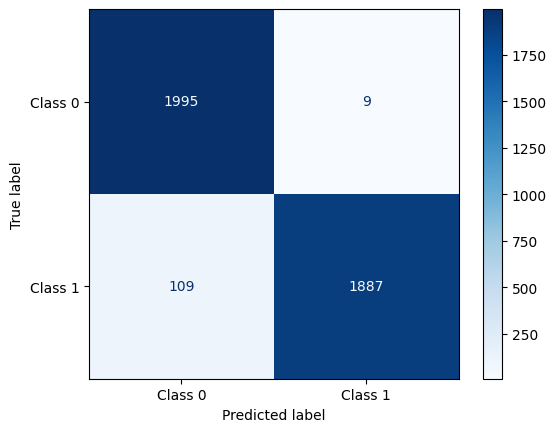

In [ ]:
from sklearn.metrics import accuracy_score

# Predict
y_test = dataset["test_label"].cpu().numpy().flatten()
y_pred_prob = model10(dataset["test_input"]).detach().cpu().numpy().flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate
acc1 = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc1:.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the matrix
print("Confusion Matrix:")
print(cm)

# Optionally, visualize it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap="Blues")

In [ ]:
model10.plot(beta=100, scale=1 , out_vars=['Class'])

### Find the symbolic equation using the Auto option / After Prune

In [ ]:

lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']


model10.auto_symbolic(lib=lib)
formula2 = model10.symbolic_formula()[0]
print(formula2)

skipping (0,0,0) since already symbolic
skipping (0,0,1) since already symbolic
skipping (0,0,2) since already symbolic
skipping (0,1,0) since already symbolic
skipping (0,1,1) since already symbolic
skipping (0,1,2) since already symbolic
skipping (0,2,0) since already symbolic
skipping (0,2,1) since already symbolic
skipping (0,2,2) since already symbolic
skipping (0,3,0) since already symbolic
skipping (0,3,1) since already symbolic
skipping (0,3,2) since already symbolic
skipping (0,4,0) since already symbolic
skipping (0,4,1) since already symbolic
skipping (0,4,2) since already symbolic
skipping (0,5,0) since already symbolic
skipping (0,5,1) since already symbolic
skipping (0,5,2) since already symbolic
skipping (0,6,0) since already symbolic
skipping (0,6,1) since already symbolic
skipping (0,6,2) since already symbolic
skipping (0,7,0) since already symbolic
skipping (0,7,1) since already symbolic
skipping (0,7,2) since already symbolic
skipping (0,8,0) since already symbolic


#### The formula

In [ ]:
from sympy import *

# Access the expression within the list before simplifying
simplify(formula2[0])

NameError: name 'formula2' is not defined

In [ ]:
from sympy import *

# Access the expression within the list before simplifying
simplify('0.088*x_1 + 0.533*x_10 - 0.283*x_12 + 0.159*x_13 + 1.570*x_14 + 0.204*x_16 - 1.677*x_18 + 3.956*x_2 - 0.345*x_3 + 0.135*x_4 - 0.074*x_5 + 0.026*x_7 - 0.739*x_9 + 0.598*(-0.557*x_1 + 0.514*x_11 + 0.458*x_14 - 0.129*x_15 + 0.106*x_16 - 0.145*x_18 + 0.152*x_2 - 0.108*x_3 + 0.055*x_4 + 0.418*x_5 - 0.073*x_7 + 0.155*x_8 - 0.491*x_9 + 0.022*sin(1.006*x_10 - 0.0151) - 0.322*sin(0.349*x_12 + 1.960) + 0.043*sin(0.555*x_13 + 3.167) + 0.978*sin(0.963*x_17 - 5.182) + 0.391*sin(0.609*x_6 - 8.389) + 1)**2 - 1.584*sin(1.038*x_11 + 1.608) + 0.207*sin(1.576*x_15 - 2.835) + 2.343*sin(0.856*x_17 - 7.791) - 0.649*sin(0.992*x_6 - 5.239) + 14.365*sin(0.0138*x_1 + 0.037*x_13 + 0.029*x_14 + 0.036*x_15 - 0.026*x_16 - 0.023*x_18 + 0.0299*x_2 + 0.021*x_3 + 0.032*x_4 - 0.0139*x_5 - 0.037*x_7 + 0.060*x_8 - 0.000*x_9 + 0.007*sin(0.902*x_10 + 0.145) + 0.039*sin(0.706*x_11 - 1.602) - 0.010*sin(1.387*x_12 + 8.598) + 0.581*sin(1.105*x_17 - 1.759) - 0.955*sin(0.422*x_6 - 4.620) + 0.089) + 22.296 - 1.615*exp(-2.041*x_8)'
)

In [ ]:

print("Variables in the symbolic formula 2:")
if isinstance(formula1[0], sympy.Expr):
    print([str(symbol) for symbol in formula1[0].free_symbols])
else:
    print("symbolic formula 2 is not a SymPy expression.")


feature_names = []
measurements = ["Measurement 1", "Measurement 2", "Measurement 3"]
metrics = ["mean", "std", "min", "max", "skew", "kurtosis"]

for i in range(3): # For each measurement (channel)
    for metric in metrics:
        feature_names.append(f"{metric}_{measurements[i]}")

# The symbolic variables x_0 to x_17 correspond to these feature_names in order.
# E.g., x_0 is mean_Measurement 1, x_1 is std_Measurement 1, ..., x_17 is kurtosis_Measurement 3.

print("\nAll possible input features (corresponding to x_0 to x_17):")
for i, name in enumerate(feature_names):
    print(f"x_{i}: {name}")

# Find missing variables in formula1[0] from the input features
present_variables_in_formula = set()
if isinstance(formula1[0], sympy.Expr):
    present_variables_in_formula = {str(symbol) for symbol in formula1[0].free_symbols}

all_input_variable_names = {f'x_{i}' for i in range(len(feature_names))}

missing_variables = all_input_variable_names - present_variables_in_formula

print("\nMissing variables in symbolic formula 2 from the input features:")
if missing_variables:
    missing_list = sorted(list(missing_variables), key=lambda x: int(x.split('_')[1]))
    for var in missing_list:
        index = int(var.split('_')[1])
        print(f"{var} ({feature_names[index]})")
else:
    print("No missing variables. The symbolic formula 2 uses all input features.")


Variables in the symbolic formula 2:
['x_11', 'x_7', 'x_5', 'x_1', 'x_13', 'x_16', 'x_10', 'x_2', 'x_9', 'x_12', 'x_4', 'x_3', 'x_14', 'x_6', 'x_17', 'x_15', 'x_18', 'x_8']

All possible input features (corresponding to x_0 to x_17):
x_0: mean_Measurement 1
x_1: std_Measurement 1
x_2: min_Measurement 1
x_3: max_Measurement 1
x_4: skew_Measurement 1
x_5: kurtosis_Measurement 1
x_6: mean_Measurement 2
x_7: std_Measurement 2
x_8: min_Measurement 2
x_9: max_Measurement 2
x_10: skew_Measurement 2
x_11: kurtosis_Measurement 2
x_12: mean_Measurement 3
x_13: std_Measurement 3
x_14: min_Measurement 3
x_15: max_Measurement 3
x_16: skew_Measurement 3
x_17: kurtosis_Measurement 3

Missing variables in symbolic formula 2 from the input features:
x_0 (mean_Measurement 1)


#### The metrics of the Symbolic formula

Evaluating symbolic formula on test set: 100%|██████████| 4000/4000 [08:45<00:00,  7.62it/s]


Accuracy of the Symbolic Formula on the test set: 0.9738
Confusion Matrix for Symbolic Formula:
[[1988   16]
 [  89 1907]]


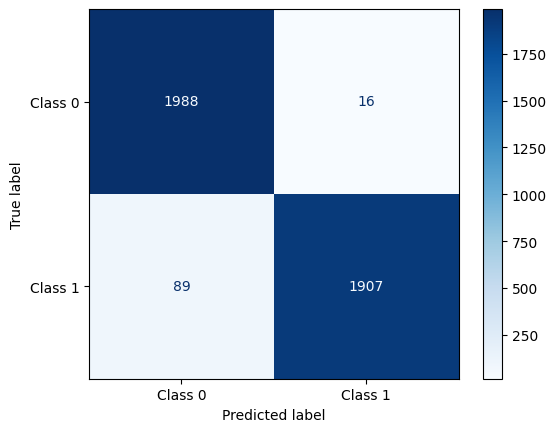

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm
import sympy

# Re-evaluating the symbolic formula on the test set
def kan_symbolic_formula_prediction_test(formula, X):
    batch = X.shape[0]
    predictions = []

    for i in tqdm(range(batch), desc="Evaluating symbolic formula on test set"):
        # Start with the base formula expression
        expression = formula


        substitutions = {sympy.Symbol(f'x_{j+1}'): X[i, j] for j in range(X.shape[1])}

        # Perform the substitution
        evaluated_expression = expression.subs(substitutions)

        # Evaluate the substituted expression numerically
        predicted = float(evaluated_expression.evalf())

        predictions.append(predicted)

    return predictions


preds_from_kan_formula_test2 = kan_symbolic_formula_prediction_test(formula2[0], dataset['test_input'].cpu().numpy())

# Convert the list of test predictions to a numpy array
preds_test_np2 = np.array(preds_from_kan_formula_test2)

# Convert raw predictions (logits) to predicted classes (0 or 1)
# Use the same threshold as the KAN model ( > 0 for BCEWithLogitsLoss)
predicted_classes_formula_test2 = (preds_test_np2 > 0).astype(float)

# Get the true test labels
true_labels_test2 = dataset['test_label'].cpu().numpy().flatten()

# Calculate accuracy on the test set
accuracy_formula_test2 = accuracy_score(true_labels_test2, predicted_classes_formula_test2)

print()

print(f"Accuracy of the Symbolic Formula on the test set: {accuracy_formula_test2:.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix for the symbolic formula predictions
cm_formula2 = confusion_matrix(true_labels_test2, predicted_classes_formula_test2)

# Print the matrix
print("Confusion Matrix for Symbolic Formula:")
print(cm_formula2)

# Optionally, visualize it
disp_formula = ConfusionMatrixDisplay(confusion_matrix=cm_formula2, display_labels=["Class 0", "Class 1"])
disp_formula.plot(cmap="Blues")

 The results

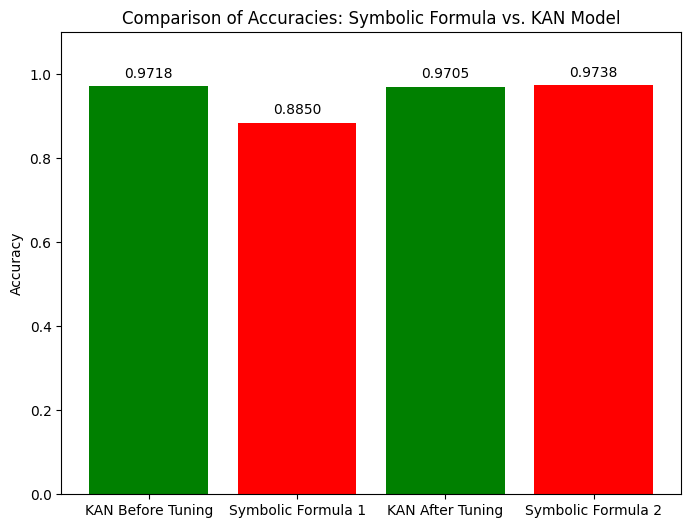

In [ ]:


import matplotlib.pyplot as plt

symbolic_accuracy1 = accuracy_formula_test1
symbolic_accuracy2 = accuracy_formula_test2
kan_accuracy_before_tuning = acc
kan_accuracy_after_tuning = acc1

# Accuracies list for plotting
labels = ['KAN Before Tuning','Symbolic Formula 1', 'KAN After Tuning' , 'Symbolic Formula 2']
accuracies = [kan_accuracy_before_tuning, symbolic_accuracy1 , kan_accuracy_after_tuning , symbolic_accuracy2]

# Plotting the accuracies
plt.figure(figsize=(8, 6))
plt.bar(labels, accuracies, color=['green', 'red', 'green' , 'red'])
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracies: Symbolic Formula vs. KAN Model')
plt.ylim(0, 1.1) # Set y-axis limit for better comparison
for i, acc_val in enumerate(accuracies):
    plt.text(i, acc_val + 0.02, f'{acc_val:.4f}', ha='center')
plt.show()


## is the symbolic equation compeired with the model's behavouir ? or with the dataset ?